In [1]:
# -- dependencies and setup --
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [22]:
# --- Python SQL toolkit and Object Relational Mapper ---
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# Reflect Tables into SQLAlchemy ORM

In [3]:
# --- create engine using the `hawaii.sqlite` database file ---
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# --- declare a Base using `automap_base()` ---
Base = automap_base()

# --- use the Base class to reflect the database tables ---
Base.prepare(engine, reflect=True)

In [5]:
# --- view all of the classes that automap found ---
Base.classes.keys()

['measurement', 'station']

In [6]:
# --- save references to each table ---
measurement = Base.classes.measurement
station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

m_columns = inspector.get_columns('measurement')
for column in m_columns:
    print(column["name"], column["type"])
print("-"*12)
s_columns = inspector.get_columns('station')
for c in s_columns:
     print(c["name"], c["type"])   

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

Checking for null values...
There are 209 null values - dropping!
Plotting precipitation data...


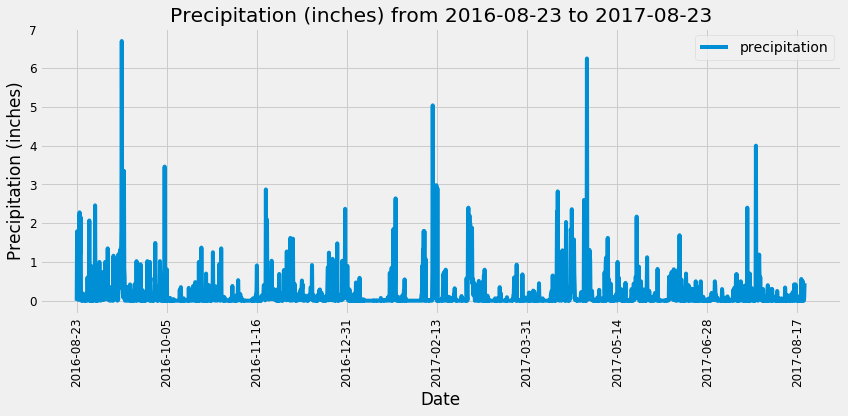

In [82]:
# ****************************************************************************************
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# ****************************************************************************************

# --- query the db and get the last data point (first in the descending order list) and find the date ---
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]

# --- convert string date to date format for use with datetime library ---
last_dt = dt.date.fromisoformat(last_date)

# --- calculate the date 1 year ago from the last data point in the database (using dt.timedelta) ---
date_oneyearago = last_dt - dt.timedelta(days=365)

# --- perform a query to retrieve the data and precipitation scores ---
prcp_data = session.query(measurement.date, measurement.prcp).\
            filter((measurement.date >= date_oneyearago)\
                    & (measurement.date <= last_dt)).all()

# --- save the query results as a Pandas DataFrame, sort by date and set the index to the date column ---
prcp_df = pd.DataFrame(prcp_data).sort_values("date").set_index("date")

# --- rename prcp column ---
prcp_df.rename(columns={"prcp":"precipitation"}, inplace=True)

# --- check and drop null values ---
print("Checking for null values...")
print(f"There are {prcp_df['precipitation'].isnull().sum()} null values - dropping!")

prcp_df.dropna(axis=0, how="any", inplace=True)

print("Plotting precipitation data...")

# --- use Pandas Plotting with Matplotlib to plot the data ---
prcp_df.plot(figsize=(12,6), fontsize=12, rot=90)
plt.title(f"Precipitation (inches) from {date_oneyearago} to {last_dt}")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

plt.tight_layout()
plt.savefig("Images/prcp.png")
plt.show()


In [83]:
# --- use Pandas to calculate the summary statistics for the precipitation data ---
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [106]:
# Design a query to show how many stations are available in this dataset?
num_station = session.query(station).count()

print("Counting from station table:")
print(f"There are {num_station} stations in the dataset.\n")

# --- using sqlalchemy distinct ---
from sqlalchemy import distinct
distinct_stations = session.query(distinct(measurement.station)).count()

print("Counting from measurement table:")
print(f"There are {distinct_stations} stations in the dataset.")

Counting from station table:
There are 9 stations in the dataset.

Counting from measurement table:
There are 9 stations in the dataset.


In [101]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(measurement.station, func.count(measurement.station)).\
                  order_by(func.count(measurement.station).desc()).\
                  group_by(measurement.station).\
                  all()

# --- display the active stations ---
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [129]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# --- identify most active station ---
most_active_station = active_stations[0][0]
print (f"The most active station is {most_active_station}.")

# --- calculate lowest temp recorded at the most active station USC00519281 ---
lowest_temp = session.query(func.min(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()
              
print(f"The lowest temperature ever observed at {most_active_station} is {lowest_temp} degrees Fahrenheit.")

# --- calculate highest temp recorded at the most active station USC00519281 ---
highest_temp = session.query(func.max(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

print(f"The highest temperature ever observed at {most_active_station} is {highest_temp} degrees Fahrenheit.")

# --- calculate average temp recorded at the most active station USC00519281 ---
avg_temp = session.query(func.avg(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

print(f"The average temperature at {most_active_station} is {round(avg_temp, 2)} degrees Fahrenheit.")

The most active station is USC00519281.
The lowest temperature ever observed at USC00519281 is 54.0 degrees Fahrenheit.
The highest temperature ever observed at USC00519281 is 85.0 degrees Fahrenheit.
The average temperature at USC00519281 is 71.66 degrees Fahrenheit.


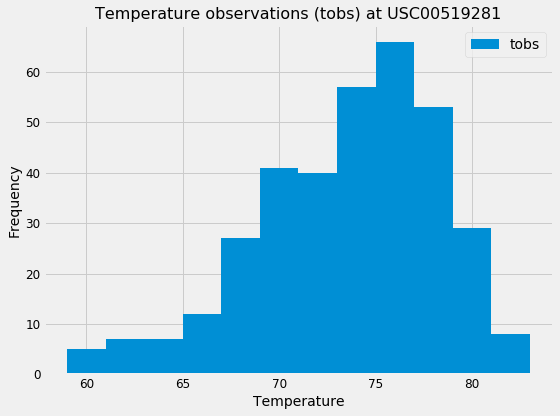

In [166]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# --- create a dataframe from temp observations in last 12 months at most active station ---
most_active_tobs = pd.DataFrame(session.query(measurement.tobs).\
                                filter((measurement.station == most_active_station)\
                                        & (measurement.date >= date_oneyearago)\
                                        & (measurement.date <= last_dt)).all())

most_active_tobs.plot(kind="hist", figsize=(8,6), bins=12, legend=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title(f"Temperature observations (tobs) at {most_active_station}", fontsize=16)

plt.tight_layout()
plt.savefig("Images/tobs.png")
plt.show()


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
